# CMPE257 Project1: E-mail Autocomplete Project

#### Yuhua He - Data preparation, preprocessing(tf-idf), K-means algorithm, Elbow method
#### Yuanzhe Li - Finding business model, preprocessing(stemming), Testing
#### Samuel Yang - Data prepraration, Documentation, preprocessing(feature extraction), Testing

### What story is the data telling us?

#### In this group assignment, the business objective we are focusing on, is the "Smart Email Compose" project. We are using the Enron email dataset, which has the "file" column and "message" column, after servel feature extracting process, we can extract more features like "file name", "message body", from", "to", "message id". So, the data is basically show what we need. It provides several thousands of messages body with completely different structure. For example, some of the messages greeting messgae that comes up with the "hello" word frequently, and some don't. In order to recognize it, we try to apply the tf-tdf technique to find out the frequency of each words. 

### What business problem can be solved using the data?

#### From what we do and trying to processing the data, "Content Discovery" can be solved easily. After we appliedK-means cluserting algorithm, we can divided all the data into several clusters where has similar words. More importantly, by applying machine-learning algorithm, we can further categorized emails into 4 major groups, which is am essential observation for our project. We also apply the eblow method to interprete and validate the consistency within cluster analysis designed to find appropriate amount of clusters we need in this situation.

In [1]:
#import Library

import email, re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import  LatentDirichletAllocation
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess

d:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Read the data into a DataFrame

emails_df = pd.read_csv('D:\FreeDownloads\enron-email-dataset\emails.csv',nrows = 10000, error_bad_lines = False)
print(emails_df.shape)

(10000, 2)


In [3]:
#Helper functions

def get_email_text(email):
    '''To get the content from email objects'''
    email_contents = []
    for email_object in email.walk():
        if email_object.get_content_type() == 'text/plain':
            email_contents.append(email_object.get_payload())
    return ''.join(email_contents)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

## Preprocessing:

In [4]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

# Parse content from emails
emails_df['content'] = list(map(get_email_text, messages))

# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)

In [5]:
#Drop rows have too less words
emails_df = emails_df[emails_df['content'].apply(lambda x: len(x.split()) > 30)]
print(emails_df.shape)

(7670, 12)


In [6]:
#Helper function - Removing stop words

def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent","a"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word, pos='v') for word in punc_free.split())
    
    return normalized

In [7]:
#Data cleaning, removing stop words

analysis_df=emails_df[['From', 'To', 'Date','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
analysis_df["clean_content"]=analysis_df.content.apply(clean)
analysis_df.head()

,From,To,Date,content,clean_content
Message-ID,,,,,
<15464986.1075855378456.JavaMail.evans@thyme>,(phillip.allen@enron.com),(john.lavorato@enron.com),2001-05-04 13:51:00-07:00,Traveling to have a business meeting takes the...,travel business meet take fun trip especially ...
<13505866.1075863688222.JavaMail.evans@thyme>,(phillip.allen@enron.com),(randall.gay@enron.com),2000-10-23 06:13:00-07:00,"Randy,\n\n Can you send me a schedule of the s...",randy send schedule salary level everyone sche...
<20641191.1075855687472.JavaMail.evans@thyme>,(phillip.allen@enron.com),(mark.scott@enron.com),2000-10-17 02:26:00-07:00,1. login: pallen pw: ke9davis\n\n I don't thi...,login pallen pw ke davis think require isp sta...
<30795301.1075855687494.JavaMail.evans@thyme>,(phillip.allen@enron.com),(zimam@enron.com),2000-10-16 06:44:00-07:00,---------------------- Forwarded by Phillip K ...,forward phillip k allen hou ect pm buckner buc...
<33076797.1075855687515.JavaMail.evans@thyme>,(phillip.allen@enron.com),(buck.buckner@honeywell.com),2000-10-16 06:42:00-07:00,"Mr. Buckner,\n\n For delivered gas behind San ...",mr buckner deliver gas behind san diego enron ...


## Comparing Data Before And After Preprocessing:

### Original Data:

In [8]:
content_simple = emails_df.content[0]
print(content_simple)

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  

My suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.



### Data After Preprocessing:

In [9]:
print(clean(emails_df.content[0]))

travel business meet take fun trip especially prepare presentation would suggest hold business plan meet take trip without formal business meet would even try get honest opinions whether trip even desire necessary far business meet think would productive try stimulate discussions across different group work often presenter speak others quiet wait turn meet might better hold round table discussion format suggestion go austin play golf rent ski boat jet ski fly somewhere take much time


In [10]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

## Elbow Method:

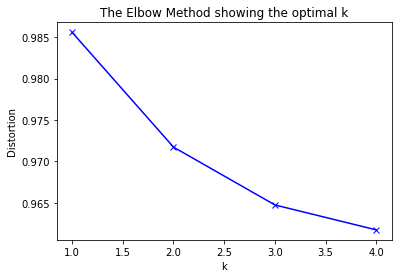

In [11]:
# make elbow plot, find k
distortions = []
k_list = range(1, 5)
for N in k_list:
    clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
    labels = clf.fit_predict(wordvector_fit)
    wordvector_fit_2d = wordvector_fit.todense()
    distortions.append(sum(np.min(cdist(wordvector_fit_2d, clf.cluster_centers_, 'euclidean'), axis=1)) / wordvector_fit_2d.shape[0])

# Plot the elbow
plt.plot(k_list, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


## K-Means Clustering Algorithm:

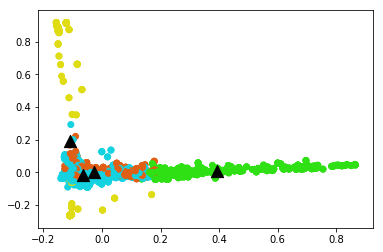

In [12]:

N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [13]:
#LDA can only use raw term counts for LDA because it is a probabilistic graphical model
features = 10
topics = 10
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=features, stop_words='english')
tf = tf_vectorizer.fit_transform(analysis_df.clean_content)
tf_feature_names = tf_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_components = topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    print (" ".join([tf_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0:
ect hou enron pm john arnold com image td font
Topic 1:
john arnold pm enron hou ect com image font td
Topic 2:
td com john pm font image enron arnold hou ect
Topic 3:
pm john com arnold td enron ect font hou image
Topic 4:
pm enron ect hou john com image arnold td font
Topic 5:
com enron pm ect hou john arnold font td image
Topic 6:
image com enron pm ect hou td john arnold font
Topic 7:
com enron pm hou ect john arnold image td font
Topic 8:
enron ect hou john pm com arnold td font image
Topic 9:
font td com pm image enron john hou arnold ect


## Gaussian Mixed Model (GMM):

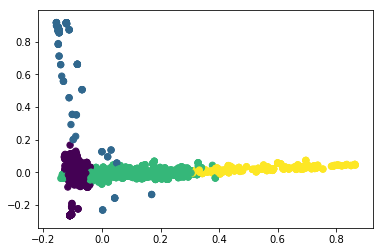

In [14]:

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(datapoint)
labels = gmm.predict(datapoint)
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels, s=40, cmap='viridis');